In [18]:
import os
import pickle
import numpy as np
import pandas as pd
from IPython.display import clear_output

import matplotlib
import matplotlib.pyplot as plt
#import config InlineBackend.figure_format = 'svg'
import tensorflow as tf

# silencing tensorflow warnings
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)
from datetime import datetime

tf.__version__ # printint out tensorflow version used
import stable_baselines
from stable_baselines.common.callbacks import BaseCallback
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines import PPO2
from stable_baselines.bench import Monitor
from stable_baselines.common.policies import MlpPolicy
from stable_baselines import results_plotter
from stable_baselines.common.evaluation import evaluate_policy
#stable_baselines.__version__ # printing out stable_baselines version used
import gym

In [2]:
with open('/Users/joshnevin/RL_FOCSLab/topologies/nsfnet_chen_5-paths_directional.h5', 'rb') as f:
    topology = pickle.load(f)
# node probabilities from https://github.com/xiaoliangchenUCD/DeepRMSA/blob/6708e9a023df1ec05bfdc77804b6829e33cacfe4/Deep_RMSA_A3C.py#L77
node_request_probabilities = np.array([0.01801802, 0.04004004, 0.05305305, 0.01901902, 0.04504505,
       0.02402402, 0.06706707, 0.08908909, 0.13813814, 0.12212212,
       0.07607608, 0.12012012, 0.01901902, 0.16916917])
load = int(1e10)
env_args = dict(topology=topology, seed=1, load = load,
                allow_rejection=False, # the agent cannot proactively reject a request
                mean_service_holding_time=1e6, # value is not set as in the paper to achieve comparable reward values
                episode_length=1000, node_request_probabilities=node_request_probabilities)

In [3]:
env = gym.make('RWAFOCS-v2', **env_args)

In [5]:
model = PPO2.load('/Users/joshnevin/RL_FOCSLab/tmp/RWAFOCS-ppo/2021-12-30_3/best_model')

/Users/joshnevin/.pyenv/versions/3.7.12/envs/rlenv37/lib/python3.7/site-packages/cloudpickle/cloudpickle.py:821: UserWarning: A pickle file created using an old (<=1.4.1) version of cloudpickle is currently being loaded. This is not supported by cloudpickle and will break in cloudpickle 1.7
  "will break in cloudpickle 1.7", category=UserWarning


In [6]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=1,deterministic =False)

In [7]:
mean_reward

711.0

In [8]:
std_reward

0.0

In [9]:
print("Whole training process statistics:")
rnd_path_action_probability = np.sum(env.actions_output, axis=1) / np.sum(env.actions_output)
rnd_wavelength_action_probability = np.sum(env.actions_output, axis=0) / np.sum(env.actions_output)
print('Path action probability:', np.sum(env.actions_output, axis=1) / np.sum(env.actions_output))
print('Wavelength action probability:', np.sum(env.actions_output, axis=0) / np.sum(env.actions_output))
num_lps_reused = env.num_lightpaths_reused
print('Load (Erlangs):', load)
print('Service bit rate (Gb/s):', env.service.bit_rate/1e9)
print('Total number of services:', env.services_processed)
print('Total number of accepted services:', env.services_accepted)
print('Blocking probability:', 1 - env.services_accepted/env.services_processed)
print('Number of services on existing lightpaths:', num_lps_reused)
print('Number of services released:', env.num_lightpaths_released)
print('Number of transmitters on each node:', env.num_transmitters)
print('Number of receivers on each node:', env.num_receivers)

Whole training process statistics:
Path action probability: [0.697609   0.30098453 0.         0.00140647 0.        ]
Wavelength action probability: [0.00562588 0.00843882 0.00281294 0.01125176 0.00421941 0.01547117
 0.01265823 0.00984529 0.00843882 0.01265823 0.01125176 0.00421941
 0.0140647  0.0140647  0.0140647  0.00843882 0.00984529 0.01547117
 0.00843882 0.00421941 0.00562588 0.00984529 0.00703235 0.00562588
 0.00843882 0.01125176 0.00843882 0.00281294 0.00984529 0.00562588
 0.00843882 0.00703235 0.01125176 0.01125176 0.00281294 0.01547117
 0.00843882 0.01547117 0.01125176 0.01547117 0.01125176 0.01125176
 0.0140647  0.02672293 0.00984529 0.0140647  0.01547117 0.00984529
 0.01125176 0.01125176 0.01265823 0.00703235 0.00703235 0.00421941
 0.00703235 0.00703235 0.00703235 0.01969058 0.00843882 0.00984529
 0.00421941 0.01125176 0.0140647  0.00843882 0.00140647 0.00843882
 0.00562588 0.00984529 0.00562588 0.00843882 0.00843882 0.00984529
 0.02390999 0.01547117 0.00984529 0.00843882 0.0

In [16]:
df = pd.read_csv("/Users/joshnevin/RL_FOCSLab/tmp/RWAFOCS-ppo/2021-12-30_3/training.monitor.csv", skiprows=1)
df

,r,l,t,episode_service_blocking_rate,service_blocking_rate
0,488,1000,8.738966,0.512,0.512
1,503,1000,13.898430,0.497,0.497
2,469,1000,18.994478,0.531,0.531
3,507,1000,24.047845,0.493,0.493
4,568,1000,29.460352,0.432,0.432
...,...,...,...,...,...
994,678,1000,5101.263800,0.322,0.322
995,686,1000,5106.395336,0.314,0.314
996,702,1000,5111.486787,0.298,0.298
997,681,1000,5116.575552,0.319,0.319


In [17]:
rewards = df['r'].to_numpy()
time = df['t'].to_numpy()
blocking_rate_ep = df['episode_service_blocking_rate']
blocking_rate = df['service_blocking_rate']

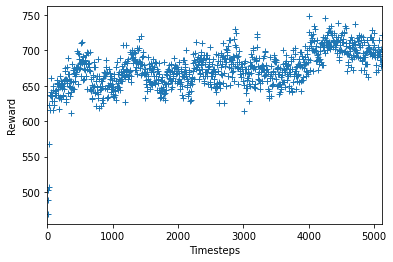

In [22]:
plt.plot(time, rewards, '+')
plt.xlim([0,time[-1]])
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.show()

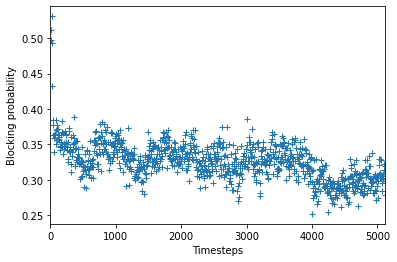

In [28]:
plt.plot(time, blocking_rate, '+')
plt.xlim([0,time[-1]])
plt.xlabel("Timesteps")
plt.ylabel("Blocking probability")
plt.show()

In [29]:
# test and visualize
obs = env.reset()
done = False
total_reward = []
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    total_reward.append(rewards)

In [30]:
sum(total_reward)

707

In [32]:
#total_reward